In [7]:
%%capture --no-stderr
%pip install -U langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [8]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [9]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}

In [10]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

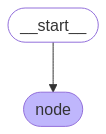

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

In [13]:
from typing_extensions import Annotated


def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

In [14]:
def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}

In [15]:
from langgraph.graph import START


graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [16]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}


graph = StateGraph(State).add_node(node).set_entry_point("node").compile()

In [17]:
input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [18]:
from langgraph.graph import MessagesState


class State(MessagesState):
    extra_field: int

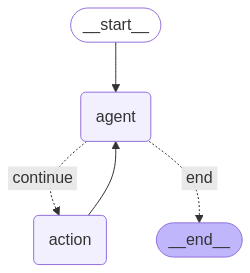

In [28]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def play_song_on_spotify(song: str):
    """Play a song on Spotify"""
    # Call the spotify API ...
    return f"Successfully played {song} on Spotify!"


@tool
def play_song_on_apple(song: str):
    """Play a song on Apple Music"""
    # Call the apple music API ...
    return f"Successfully played {song} on Apple Music!"


tools = [play_song_on_apple, play_song_on_spotify]
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o-mini")
model = model.bind_tools(tools, parallel_tool_calls=False)


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")


memory = MemorySaver()


# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Can you play Eminem's most popular song?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you play Eminem's most popular song?
================================== Ai Message ==================================
Tool Calls:
  play_song_on_apple (call_dyzjLxSIy3QahiS6itCjxFGw)
 Call ID: call_dyzjLxSIy3QahiS6itCjxFGw
  Args:
    song: Lose Yourself by Eminem
================================= Tool Message =================================
Name: play_song_on_apple

Successfully played Lose Yourself by Eminem on Apple Music!
================================== Ai Message ==================================

I've started playing "Lose Yourself" by Eminem on Apple Music! Enjoy the song!


In [30]:
all_states = []
for state in app.get_state_history(config):
    print(state)
    all_states.append(state)
    print("--")

StateSnapshot(values={'messages': [HumanMessage(content="Can you play Eminem's most popular song?", additional_kwargs={}, response_metadata={}, id='dd1b74af-ec40-4f7d-9c1a-387ac570d5c0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dyzjLxSIy3QahiS6itCjxFGw', 'function': {'arguments': '{"song":"Lose Yourself by Eminem"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 80, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BGmx4WsNrg1qQ6sjocvUqL8CQYn4Z', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cd35329e-6bb3-45a1-94c0-ec05f2df884d-0', tool_calls=[{'name': 'play_song_on_apple', 'arg

In [31]:
to_replay = all_states[2]

In [32]:
to_replay.values

{'messages': [HumanMessage(content="Can you play Eminem's most popular song?", additional_kwargs={}, response_metadata={}, id='dd1b74af-ec40-4f7d-9c1a-387ac570d5c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dyzjLxSIy3QahiS6itCjxFGw', 'function': {'arguments': '{"song":"Lose Yourself by Eminem"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 80, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BGmx4WsNrg1qQ6sjocvUqL8CQYn4Z', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cd35329e-6bb3-45a1-94c0-ec05f2df884d-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Lose 

In [33]:
to_replay.next

('action',)

In [34]:
for event in app.stream(None, to_replay.config):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='Successfully played Lose Yourself by Eminem on Apple Music!', name='play_song_on_apple', id='c44de2d4-35aa-411d-b5e6-2efa44b34d91', tool_call_id='call_dyzjLxSIy3QahiS6itCjxFGw')]}
{'messages': [AIMessage(content='I\'ve started playing "Lose Yourself" by Eminem on Apple Music! Enjoy the song!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 123, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BGmy2RcKaotecQDSsb7Ks18nf7k2F', 'finish_reason': 'stop', 'logprobs': None}, id='run-b6fd1473-8fbf-4555-a38c-fbdc9d498ed9-0', usage_metadata={'input_tokens': 123, 'output_tokens': 20, 'total_tokens': 143, 'input_token_details': {'

In [35]:
from langchain_core.messages import AIMessage

# Let's now get the last message in the state
# This is the one with the tool calls that we want to update
last_message = to_replay.values["messages"][-1]

# Let's now get the ID for the last message, and create a new message with that ID.
new_message = AIMessage(
    content="It's quiet hours so I can't play any music right now!", id=last_message.id
)

branch_config = app.update_state(
    to_replay.config,
    {"messages": [new_message]},
)

In [36]:
branch_state = app.get_state(branch_config)

In [37]:
branch_state.values

{'messages': [HumanMessage(content="Can you play Eminem's most popular song?", additional_kwargs={}, response_metadata={}, id='dd1b74af-ec40-4f7d-9c1a-387ac570d5c0'),
  AIMessage(content="It's quiet hours so I can't play any music right now!", additional_kwargs={}, response_metadata={}, id='run-cd35329e-6bb3-45a1-94c0-ec05f2df884d-0')]}

In [38]:
branch_state.next

()